<a href="https://colab.research.google.com/github/AnshumanNigam/DrugDiscovery/blob/main/Module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computational Drug Discovery [Module 2] Exploratory Data Analysis**

In **Module 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

Read more here: https://towardsdatascience.com/a-gentle-introduction-to-exploratory-data-analysis-f11d843b8184

---

## **Install conda and rdkit**
RDKit is open-source toolkit for cheminformatics. We will use it to calculate descriptors.

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
! pip install deepchem
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## **Load bioactivity data**
This is the same file you generated at the end of last module.

In [ ]:
! wget https://raw.githubusercontent.com/redrodeo03/QSTP-drug/main/acetylcholinesterase_03_bioactivity_data_curated.csv

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('acetylcholinesterase_03_bioactivity_data_curated.csv')
df

In [ ]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [ ]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [ ]:
df_lipinski

In [ ]:
df

Now, let's combine the 2 DataFrame

In [ ]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [ ]:
df_combined

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column
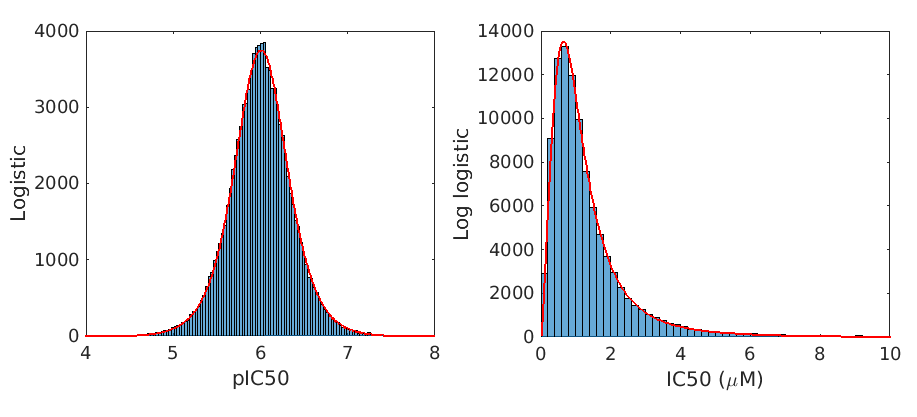

In [ ]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)

    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [ ]:
df_combined.standard_value.describe()

In [ ]:
-np.log10( (10**-9)* 100000000 )

In [ ]:
-np.log10( (10**-9)* 10000000000 )

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)

    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [ ]:
df_norm = norm_value(df_combined)
df_norm

In [ ]:
df_norm.standard_value_norm.describe()

In [ ]:
df_final = pIC50(df_norm)
df_final

In [ ]:
df_final.pIC50.describe()

Let's write this to CSV file.

In [ ]:
df_final.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

Let's write this to CSV file.

In [ ]:
df_2class.to_csv('acetylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

#### **MW**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

#### **LogP**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

#### **NumHDonors**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

#### **NumHAcceptors**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf